In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [47]:
""" %matplotlib inline
%config InlineBackend.figure_format = 'retina'"""

import warnings

from tqdm.notebook import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial

import numpy as np
import pandas as pd
import scipy.stats as ss
import os
import pickle

from scipy.optimize import curve_fit


#import statsmodels.formula.api as smf
from scipy.stats import zscore, pearsonr, spearmanr
from scipy.stats import ttest_ind


#from neurodsp.spectral import compute_spectrum
#from fooof import FOOOF

""" import seaborn as sns
sns.set_style('whitegrid')"""

import matplotlib.pyplot as plt
#from matplotlib import cm, rc



In [3]:
import numba
print(numba.__version__)


0.59.0


### Read pickle files  - organoid foof results and metadata

In [4]:
#get pickle results in folder

pickle_org_metadata= '/Users/blancamartin/Desktop/Voytek_Lab/timescales/organoid_pickle_files/organoid_metadata_clean.pkl'
pickle_org_fooof  = '/Users/blancamartin/Desktop/Voytek_Lab/timescales/organoid_pickle_files/workflow_run_fooof_2023-08-14_1423.pkl'


In [5]:
#load pickle files

organoid_metadata_clean = pd.read_pickle(pickle_org_metadata)


wf = pd.read_pickle(pickle_org_fooof)

In [6]:
knee_freq_range = (0.01,9.99)
zscore_thresh = 4
spec_type =  'Welch' # 'Welch' or 'AR_3'
spec_type_i = 0 # parallels spec_types to index the data
knee_no_2 = False # for summary plots, if single knee leave false, if double use false/true for knee 1/2

In [7]:
n_fits,n_spec_types = wf.results.shape
days = [organoid_metadata_clean['day_postdiff'].iloc[i] for i in range(n_fits)]
if knee_no_2:
    taus = [wf.results[i][spec_type_i].tau_double for i in range(n_fits)]
    knee_freqs = [wf.results[i][spec_type_i].knee_freq_double for i in range(n_fits)]
    rsqs = [wf.results[i][spec_type_i].rsq for i in range(n_fits)]
else:
    taus = [wf.results[i][spec_type_i].tau for i in range(n_fits)]
    knee_freqs = [wf.results[i][spec_type_i].knee_freq for i in range(n_fits)]
    rsqs = [wf.results[i][spec_type_i].rsq for i in range(n_fits)]

unique_recordings = np.unique(organoid_metadata_clean['day_postdiff'])
unique_wells = np.unique(organoid_metadata_clean['well'].values)
unique_channels = np.unique(organoid_metadata_clean['channel'])
n_recordings = len(unique_recordings); n_wells = len(unique_wells); n_channels = len(unique_channels)
compiled_data_taus = np.full((n_recordings,n_wells,n_channels),np.nan)
compiled_data_knee_freqs = np.full((n_recordings,n_wells,n_channels),np.nan)
compiled_data_days = np.full((n_recordings,n_wells,n_channels),np.nan)
compiled_data_rsqs = np.full((n_recordings,n_wells,n_channels),np.nan)
for rec_i,recording in enumerate(unique_recordings):
    for well_i,well in enumerate(unique_wells):
        for channel_i,channel in enumerate(unique_channels):
            this_idx_np = np.where((organoid_metadata_clean['day_postdiff'] == recording) & (organoid_metadata_clean['well'].values == well) & (organoid_metadata_clean['channel'].values == channel))[0]
            if np.size(this_idx_np) > 0:
                if len(this_idx_np) > 1:
                    breakme
                this_idx = this_idx_np[0]
                compiled_data_taus[rec_i,well_i,channel_i] = taus[this_idx]
                compiled_data_knee_freqs[rec_i,well_i,channel_i] = knee_freqs[this_idx]
                compiled_data_days[rec_i,well_i,channel_i] = days[this_idx]
                compiled_data_rsqs[rec_i,well_i,channel_i] = rsqs[this_idx]

knee_freq_mask = (compiled_data_knee_freqs < knee_freq_range[0]) | (compiled_data_knee_freqs > knee_freq_range[1])
compiled_data_taus_kfm = np.copy(compiled_data_taus); compiled_data_taus_kfm[knee_freq_mask] = np.nan
compiled_data_knee_freqs_kfm = np.copy(compiled_data_knee_freqs); compiled_data_knee_freqs_kfm[knee_freq_mask] = np.nan
compiled_data_days_kfm = np.copy(compiled_data_days); compiled_data_days_kfm[knee_freq_mask] = np.nan
compiled_data_rsqs_kfm = np.copy(compiled_data_rsqs); compiled_data_rsqs_kfm[knee_freq_mask] = np.nan

rsq_mask = compiled_data_rsqs < 0.9
compiled_data_taus_kfm_rsq = np.copy(compiled_data_taus_kfm); compiled_data_taus_kfm_rsq[rsq_mask] = np.nan
compiled_data_rsqs_kfm_rsq = np.copy(compiled_data_rsqs_kfm); compiled_data_rsqs_kfm_rsq[rsq_mask] = np.nan

dims_compiled = compiled_data_taus_kfm_rsq.shape
compiled_data_taus_kfm_rsq_vec = np.reshape(compiled_data_taus_kfm_rsq, (dims_compiled[0], np.product(dims_compiled[1:])))

compiled_data_taus_kfm_rsq_vec[np.abs(zscore(compiled_data_taus_kfm_rsq_vec,axis=1,nan_policy='omit')) >= zscore_thresh] = np.nan

In [8]:
days_in = compiled_data_days_kfm.ravel()
data_in = np.log10(compiled_data_taus_kfm_rsq_vec.ravel())



# remove nans
days_in = days_in[~np.isnan(data_in)]
data_in = data_in[~np.isnan(data_in)]

# normalize days
days_np = np.array(days_in)
days_in = (days_np - days_np.min()) / (days_np - days_np.min()).max()

# Create a mask based on the condition (time >= 0.2)

mask = [t >= 0.2 for t in days_in]

# Use the mask to filter both time and data
days_in = np.asarray([t for i, t in enumerate(days_in) if mask[i]])
data_in = np.asarray([d for i, d in enumerate(data_in) if mask[i]])





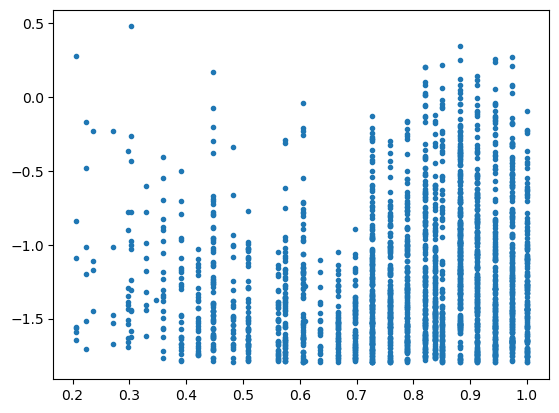

In [9]:
plt.plot(days_in, data_in, '.')

## Hypotheses fitting (for figure 2 for timescale dev paper)

In [10]:
def rsq(xdata, ydata, popt, f):
    
    #residual sum of squares
    residuals = ydata- f(xdata, *popt)
    ss_res = np.sum(residuals**2)
    #total sum of squares
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    
    r_squared = 1 - (ss_res / ss_tot)
    
    return r_squared
    

In [11]:
def f_test(xdata, ydata, model0, model1, popt0, popt1, p0, p1):

    yfit0 = model0(xdata, *popt0)
    yfit1 = model1(xdata, *popt1)

    ssq0 = ((yfit0-ydata)**2).sum()
    ssq1 = ((yfit1-ydata)**2).sum()
    
    param_diff = p1 - p0

    
    if param_diff == 0:
        df_0 = len(xdata) - p0
    
        df_1 = len(xdata) - p1
    
        f_orgio = ssq1/ssq0
        p = 1 - ss.f.cdf(f_orgio, df_0, df_1)
    else:
        df = len(xdata) - p1

        f_orgio = ((ssq0 - ssq1) / param_diff) / (ssq1 / df)
        p = 1 - ss.f.cdf(f_orgio, param_diff, df)

    return f_orgio, p

In [12]:
# Define the Gaussian function
def gaussian(x,a,x0,sigma, c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))  + c
# Define the sigmoid function
def sigmoid(x, A, B, C, D):
    return A / (1 + np.exp(-C * (x - B))) + D

# Define the horizontal line function (constant)
def horizontal_line(x, A):
    return A

In [13]:
def fit_hyp(divs, taus, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid):
    
    
    # Fit the Gaussian function to your data
    params_gaussian, _ = curve_fit(gaussian, divs, taus, p0=guess_gaussian, bounds=bounds_gaussian, maxfev=2000)

    # Fit the sigmoid function to your data
    params_sigmoid, _ = curve_fit(sigmoid, divs, taus, p0=guess_sigmoid,method='dogbox', maxfev=2000)

    # Fit the horizontal line to your data
    params_horizontal_line, _ = curve_fit(horizontal_line, divs, taus)


    return params_horizontal_line, params_sigmoid, params_gaussian

In [14]:
def plt_hyp(divs, taus, params_horizontal_line, params_sigmoid, params_gaussian, ylim=None ):
    
    # Create a range of x values for plotting
    x_fit = np.linspace(min(divs), max(divs), 100)

    # Calculate the corresponding y values using the fitted parameters for each function
    y_fit_gaussian = gaussian(x_fit, *params_gaussian)
    y_fit_sigmoid = sigmoid(x_fit, *params_sigmoid)
    y_fit_horizontal_line = horizontal_line(x_fit, params_horizontal_line[0])

    # Plot the data and the fitted functions
    plt.figure(figsize =  (6,5))
    # Create the scatter plot of the data
    plt.plot(divs, taus, '.', color = "dimgrey")
    #plt.ylabel("Log(timescales)", size = 18)
    #plt.xlabel("Days ", size = 18)
    plt.xticks(size = 13)
    plt.yticks(size = 13)

    plt.axhline(y=params_horizontal_line[0], xmin = 0.04, xmax = 0.98, color='#FDAE61', linestyle='-.', linewidth=5,dashes=(5,2))
    plt.plot(x_fit, y_fit_sigmoid, '-.', color='#2D7BB6', linewidth=5, dashes=(4,2))
    plt.plot(x_fit, y_fit_gaussian, '-.',color='#D7191D', linewidth=5, dashes=(2, 2))
    
    if ylim:
        plt.ylim(ylim[0],ylim[1])

    
    """
    days_pn = ['6', '11', '16', '21','26','31']
    
    locs, labels = plt.xticks()
    print(locs)
    labels = days_pn
    plt.xticks(locs[1:-1], labels)"""
    plt.show()

### Log version

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


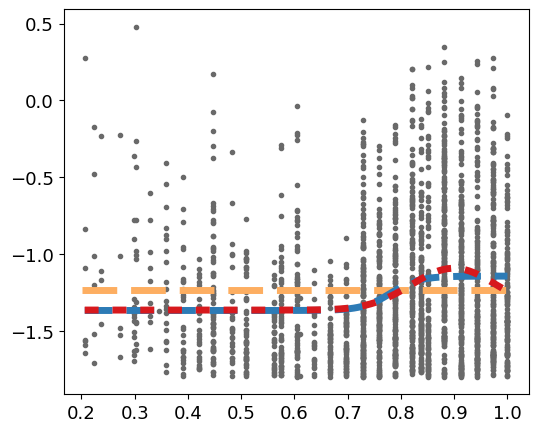

In [15]:
# guesses
guess_sigmoid = [
    0.3, # amplitude
    np.max(days_in), # mean
    np.max(days_in)/10, # standard deviation
    -1.4 # offset
]
guess_gaussian = [
    np.max(data_in), # amplitude
    np.max(days_in), # mean
    np.max(days_in)/10, # standard deviation
    np.min(data_in) # offset
]

bounds_gaussian = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])

bounds_sigmoid = ([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])

#fit_method = 'trf' # 'lm', 'trf', 'dogbox'
params_horizontal_line, params_sigmoid, params_gaussian = fit_hyp(days_in, data_in, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)

#plot
plt_hyp(days_in, data_in, params_horizontal_line, params_sigmoid, params_gaussian, ylim=None )


### Compute rsqs for fits - log version

In [16]:
#get r-squared values

rsqs_org_h0 = rsq(days_in,  data_in, params_horizontal_line, horizontal_line) 
rsqs_org_h1 = rsq(days_in,  data_in, params_sigmoid, sigmoid) 
rsqs_org_h2 = rsq(days_in,  data_in, params_gaussian, gaussian) 

print("rsq org h0:", rsqs_org_h0)
print("rsq org h1:", rsqs_org_h1)
print("rsq org h2:", rsqs_org_h2)

rsq org h0: 0.0
rsq org h1: 0.045134394541365475
rsq org h2: 0.0512061495133832


### f-tests

In [17]:

#f-tests
f_test_h0_h1 = f_test(days_in, data_in, horizontal_line, sigmoid,
                      params_horizontal_line, params_sigmoid, 1, 4)
f_test_h0_h2 = f_test(days_in, data_in, horizontal_line, gaussian, 
                      params_horizontal_line, params_gaussian,1,4)
f_test_h2_h1 = f_test(days_in, data_in, gaussian, sigmoid, 
                      params_gaussian, params_sigmoid,4,4)

print("f_test org h0 vs h1:", f_test_h0_h1)
print("f_test org h0 vs h2:", f_test_h0_h2)
print("f_test org h1 vs h2:", f_test_h2_h1)

f_test org h0 vs h1: (37.29429260993528, 1.1102230246251565e-16)
f_test org h0 vs h2: (42.582118281371834, 1.1102230246251565e-16)
f_test org h1 vs h2: (1.0063994459585754, 0.4383476514623941)


#### Run t test to compare data around gaussian peak and end - compare ALL the datapoints at the timepoint closes to the gaussian peak to all the datapoints for the final timepoint 

In [18]:
gaussian_peak = params_gaussian[1]

In [19]:
gaussian_peak

0.8990702452660996

In [20]:
#get timepoint closest to gaussian peak
# Calculate absolute differences between each time point and the given time point
differences = np.abs(np.array(days_in) - gaussian_peak)

# Find the index corresponding to the minimum difference
closest_index = np.argmin(differences)

# Get the time point closest to the given time point
closest_timepoint = days_in[closest_index]

print("Closest Time Point:", closest_timepoint)

Closest Time Point: 0.9122807017543859


In [21]:
# Calculate the mean of data associated with the closest time point
data_at_closest_timepoint = [data_in[i] for i, t in enumerate(days_in) if t == closest_timepoint]
mean_data_at_closest_timepoint = np.mean(data_at_closest_timepoint)

print("Mean of Data Associated with Closest Time Point ", gaussian_peak, ":", mean_data_at_closest_timepoint)


Mean of Data Associated with Closest Time Point  0.8990702452660996 : -1.1409336248327175


In [22]:
# Filter time points that occur before the given time point
filtered_timepoints = [time_point for time_point in days_in  if time_point < gaussian_peak]

# If there are filtered time points, find the one closest to the given time point
if filtered_timepoints:
    closest_timepoint_before = max(filtered_timepoints)
else:
    closest_timepoint_before = None

print("Closest Time Point before", gaussian_peak, ":", closest_timepoint_before)


Closest Time Point before 0.8990702452660996 : 0.881578947368421


In [23]:
# Calculate the mean of data associated with the closest time point
data_at_closest_timepoint_before = [data_in[i] for i, t in enumerate(days_in) if t == closest_timepoint_before]

mean_data_at_closest_timepoint_before = np.mean(data_at_closest_timepoint_before)


print("Mean of Data Associated with Closest Time Point before", gaussian_peak, ":", mean_data_at_closest_timepoint_before)


Mean of Data Associated with Closest Time Point before 0.8990702452660996 : -0.9875796736173439


In [24]:
# Get the last time point
last_timepoint = max(days_in)
print("Last Time Point:", last_timepoint)

# Find the indices where the time array equals the last time point
last_timepoint_indices = np.where(days_in == last_timepoint)[0]

# Get the data associated with the last time point
data_at_last_timepoint = data_in[last_timepoint_indices]

# Calculate the mean of the data associated with the last time point
mean_data_at_last_timepoint = np.mean(data_at_last_timepoint)


print("Mean of Data at Last Time Point:", mean_data_at_last_timepoint)


Last Time Point: 1.0
Mean of Data at Last Time Point: -1.2530159225356254


#### Run t-tests - independent although we have a mix of independent and paired samples and a mixed-effects model or anova might be more appropiate?

T-statistic: 2.2891078394996116
P-value: 0.022683879609404996
Degrees of Freedom after point: 341
Reject the null hypothesis: There is a significant difference between the means of the two arrays.


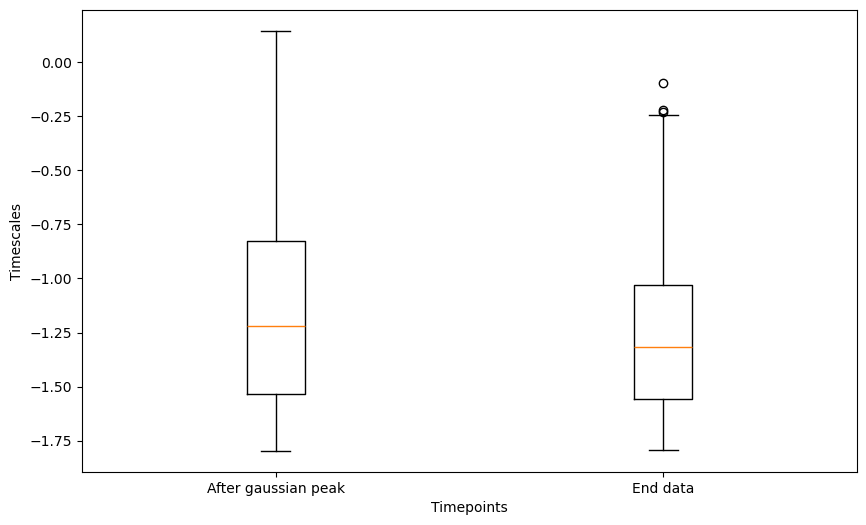

In [46]:
#after gausssian timepoint
# Perform t-test
t_statistic, p_value = ttest_ind(data_at_closest_timepoint, data_at_last_timepoint)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Calculate degrees of freedom
degrees_of_freedom = len(data_at_closest_timepoint) + len(data_at_last_timepoint) - 2

# Print the result
print("Degrees of Freedom after point:", degrees_of_freedom)

# Interpret the p-value
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means of the two arrays.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means of the two arrays.")


# Create box plot
plt.figure(figsize=(10, 6))

plt.boxplot([data_at_closest_timepoint, data_at_last_timepoint], labels=['After gaussian peak', 'End data'])

plt.xlabel('Timepoints')
plt.ylabel('Timescales')


plt.show()

T-statistic: 5.685644947791122
P-value: 2.6056669692540153e-08
Reject the null hypothesis: There is a significant difference between the means of the two arrays (before timepoint).
Degrees of Freedom before point: 379


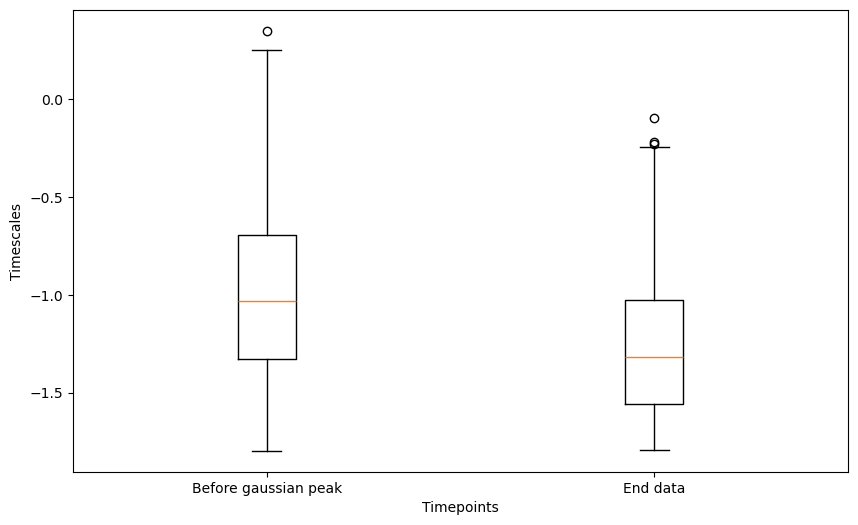

In [42]:
#before gausssian timepoint
# Perform t-test
t_statistic, p_value = ttest_ind(data_at_closest_timepoint_before, data_at_last_timepoint)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the p-value
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means of the two arrays (before timepoint).")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means of the two arrays.")

# Calculate degrees of freedom
degrees_of_freedom = len(data_at_closest_timepoint_before) + len(data_at_last_timepoint) - 2

# Print the result
print("Degrees of Freedom before point:", degrees_of_freedom)

# Create box plot
plt.figure(figsize=(10, 6))

plt.boxplot([data_at_closest_timepoint_before, data_at_last_timepoint], labels=['Before gaussian peak', 'End data'])

plt.xlabel('Timepoints')
plt.ylabel('Timescales')


plt.show()

## Mean analysis

### Get mean days and timescales

In [25]:
def get_mean_std_recday (taus, divs):
    days = sorted(set(divs))
    all_indices = []
    days_taus = []
    mean_taus = []
    std_taus = []

    #get indices for each day

    for d in days:
   
        indices = [i for i, x in enumerate(divs) if x == d]

        
        all_indices.append(indices)
        #get taus for those indices
        day_taus = taus[indices]
        days_taus.append(day_taus)
        #get means and stds
        mean_taus.append(np.mean(day_taus))
        std_taus.append(np.std(day_taus))
        
    return [days, all_indices, days_taus, mean_taus, std_taus]

In [26]:
days, all_indices,days_taus_filt, mean_taus_filt, std_filt = get_mean_std_recday(data_in, days_in)

Text(0.5, 1.0, 'Mean day taus')

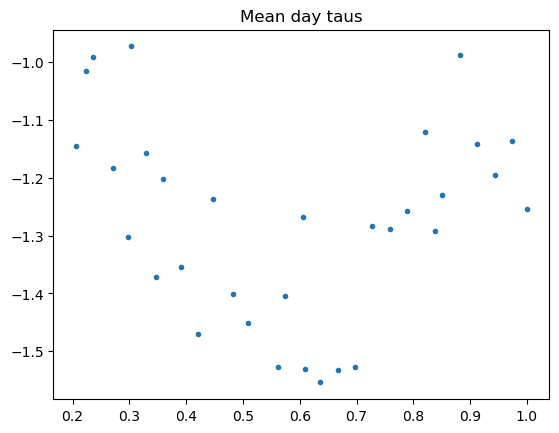

In [27]:
#plot the mean
plt.plot(days, mean_taus_filt, '.')
plt.title("Mean day taus")

### Fit the mean 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


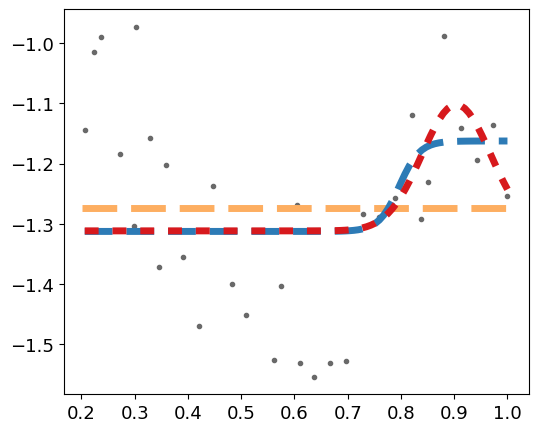

In [28]:
#Linear

# Guess and bounds for Gaussian fit
# guesses
guess_sigmoid = [
    np.max(data_in), # amplitude
    np.min(data_in), # offset
    np.max(days_in)/10, # gain
    np.max(days_in) # midpoint
]
guess_gaussian = [
    np.max(data_in), # amplitude
    np.max(days_in), # mean
    np.max(days_in)/10, # standard deviation
    np.min(data_in) # offset
]

bounds_gaussian = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])

bounds_sigmoid = ([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])

params_horizontal_line_mean, params_sigmoid_mean, params_gaussian_mean = fit_hyp(days, mean_taus_filt, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)

#plot
plt_hyp(days,  mean_taus_filt, params_horizontal_line_mean, params_sigmoid_mean, params_gaussian_mean, ylim=None )


### Calculate rsq for mean

In [29]:
#get r-squared values

rsqs_org_h0 = rsq(days,  mean_taus_filt,params_horizontal_line_mean, horizontal_line) 
rsqs_org_h1 = rsq(days,  mean_taus_filt,  params_sigmoid_mean, sigmoid) 
rsqs_org_h2 = rsq(days,  mean_taus_filt, params_gaussian_mean, gaussian) 

print("rsq org h0:", rsqs_org_h0)
print("rsq org h1:", rsqs_org_h1)
print("rsq org h2:", rsqs_org_h2)

rsq org h0: 0.0
rsq org h1: 0.13503763922065937
rsq org h2: 0.15022234506734944


### f-tests for mean

In [30]:

#f-tests
f_test_h0_h1 = f_test(days, mean_taus_filt, horizontal_line, sigmoid,
                      params_horizontal_line_mean, params_sigmoid_mean, 1, 4)
f_test_h0_h2 = f_test(days, mean_taus_filt, horizontal_line, gaussian, 
                      params_horizontal_line_mean, params_gaussian_mean,1,4)
f_test_h2_h1 = f_test(days, mean_taus_filt, gaussian, sigmoid, 
                      params_gaussian_mean, params_sigmoid_mean,4,4)

print("f_test org h0 vs h1:", f_test_h0_h1)
print("f_test org h0 vs h2:", f_test_h0_h2)
print("f_test org h1 vs h2:", f_test_h2_h1)

f_test org h0 vs h1: (1.4571169296398405, 0.2475034633207953)
f_test org h0 vs h2: (1.6499318527500189, 0.20039489634531682)
f_test org h1 vs h2: (1.0178690340450214, 0.4814786425240152)
